In [1]:
import sys
from pathlib import Path

# Add parent directory to path so we can import utils_pdhg
sys.path.insert(0, str(Path('.').resolve().parent))

import torch
import json 
from omegaconf import DictConfig, OmegaConf 
from hydra import initialize, compose 
from types import SimpleNamespace

OmegaConf.register_new_resolver("div", lambda x, y: x // y)

typedict = {"float16":torch.float16, "float32":torch.float32, "bfloat16":torch.bfloat16} 

from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from omegaconf import OmegaConf

# Optionally: provide overrides like on the CLI
overrides = [
    "model=gpt-tiny",
    "optimizer=my_adamw",
    "data=shakespeare",
    "training=shakespeare",
]

# Hydra’s Launcher will use sys.argv, so we simulate a CLI:
import sys
old_argv = sys.argv
try:
    sys.argv = [old_argv[0]] + overrides
    logger = main()  # this calls the @hydra.main-wrapped function
finally:
    sys.argv = old_argv

Hydra run directory: /mnt/home/tparshakova/Documents/GPT-opt/tests/gpt-tiny-attn-kq/outputs/gpt-tiny/default/tiny_shakespeare/my_adamw/bs-4-lr-0.001-wd-0
Using device: cuda
Training on dataset tiny_shakespeare


/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Load data from /mnt/ceph/users/cmodi/huggingface/tiny_shakespeare-gpt2/
Initialized train dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Initialized val dataloader in 0 at :  {'rank': 0, 'position': 0, 'shard': 0}
Length of train dataset : 0.3 million tokens
Length of validation dataset : 0.0 million tokens
Total number of iterations : 147

Training with optimizer my_adamw and learning rate 0.001
Set pass_loss to False for optimizer MyAdamW
Accumulate gradient for 2 steps
Will not save checkpoints as no directory is specified
Epoch 1 of 1
Rank 0 reached end of train dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
In rank: 0, epoch 1, Train Loss: 5.924845218658447
In rank: 0, time taken for epoch 1 :  11.26446795463562
Rank 0 reached end of val dataloader. Resetting to :  {'rank': 0, 'position': 0, 'shard': 0}
Validation Loss: 6.079560279846191
In rank: 0, epoch 1, Validation Loss: 6.079560279846191
Saved output to /mnt/home/tparshakova/Documents/GPT-opt

In [3]:
with initialize(config_path="../../hydra_conf", version_base=None):
    config = compose(config_name="config", overrides=overrides)


# Paste the hydra_run_dir printed by main() here:
output_dir = "/mnt/home/tparshakova/Documents/GPT-opt/tests/gpt-tiny-attn-kq/outputs/gpt-tiny/default/tiny_shakespeare/my_adamw/bs-4-lr-0.001-wd-0"

output_path = make_output_path_hydra(config, output_dir)
print("output_path:", output_path)

with open(output_path) as f:
    d = json.load(f)

logger = SimpleNamespace(**d)

output_path: /mnt/home/tparshakova/Documents/GPT-opt/tests/gpt-tiny-attn-kq/outputs/gpt-tiny/default/tiny_shakespeare/my_adamw/bs-4-lr-0.001-wd-0/my_adamw-lr-0.001-constant-linear-45d3f35197e78307db5aeb1d9ceb488b.json


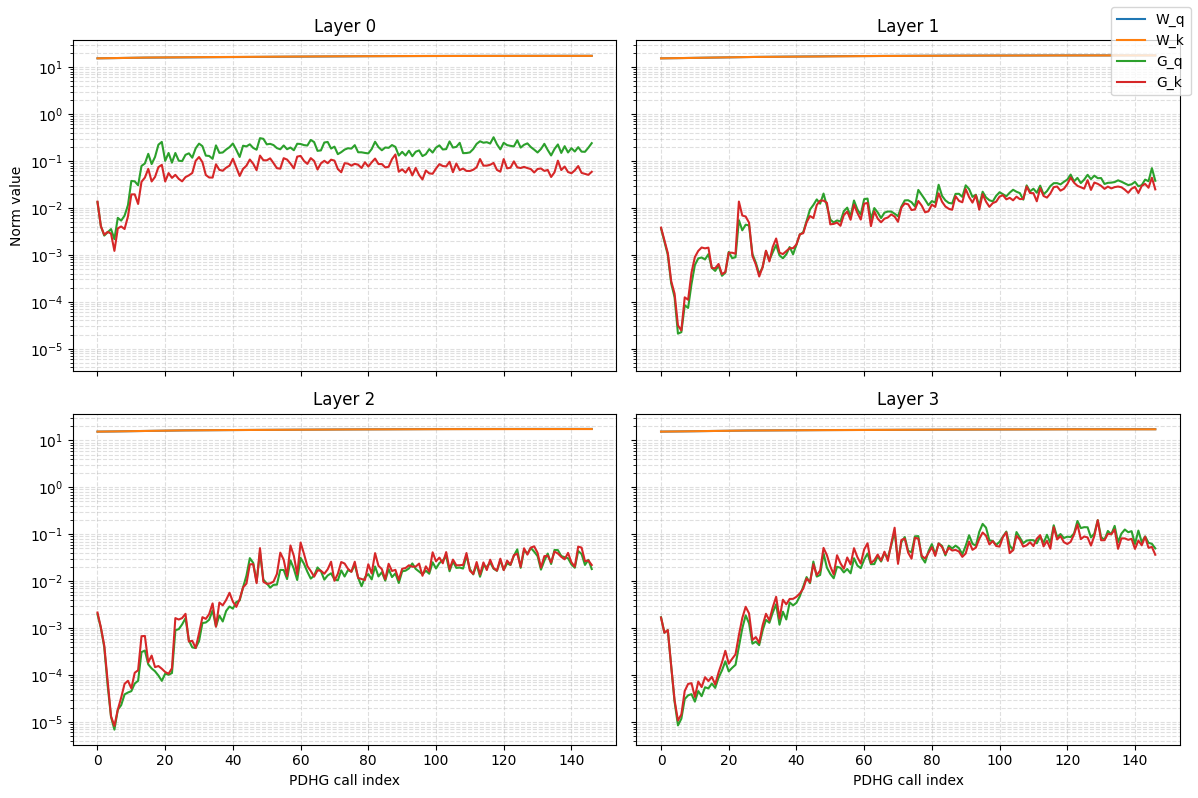

In [4]:
import numpy as np
import matplotlib.pyplot as plt

layer_indices = sorted({
    layer_idx
    for it_res in logger.pdhg_residuals
    for layer_idx in it_res.keys()
})

calls = np.arange(len(logger.pdhg_residuals))

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, layer_idx in zip(axes, layer_indices):
    W_q_norms, W_k_norms, G_q_norms, G_k_norms = [], [], [], []
    for it_res in logger.pdhg_residuals:
        layer_res = it_res.get(layer_idx)
        if layer_res is None:
            W_q_norms.append(np.nan); W_k_norms.append(np.nan)
            G_q_norms.append(np.nan); G_k_norms.append(np.nan)
        else:
            W_q_norms.append(layer_res["W_q_norm"])
            W_k_norms.append(layer_res["W_k_norm"])
            G_q_norms.append(layer_res["G_q_norm"])
            G_k_norms.append(layer_res["G_k_norm"])

    ax.plot(calls, W_q_norms, label="W_q")
    ax.plot(calls, W_k_norms, label="W_k")
    ax.plot(calls, G_q_norms, label="G_q")
    ax.plot(calls, G_k_norms, label="G_k")
    ax.set_title(f"Layer {layer_idx}")
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.4)

axes[0].set_ylabel("Norm value")
axes[2].set_xlabel("PDHG call index")
axes[3].set_xlabel("PDHG call index")

# One shared legend for all axes
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()